# Multi-Channel Pulses

Usually there is a need to define pulses for multiple control channels simulateously. While this would be possible by simply defining several separate pulse templates (one for each channel), qupulse also allows to define pulse templates directly for multiple channels or combine existing templates in a multi-channel way. This tutorial explores these possibilities.

## A Multi-Channel Table Pulse
`TablePulseTemplate` allows to model multiple channels in a straighforward way: In its constructor entries are given as time-voltage sequences in a dictionary where each key specifies a channel id (which can be an identifier string or a number). In the first few examples we have mostly ignored this but here we are making use of it.

The following example constructs a 2-channel table pulse template with shared parameters and plots it.

The number of channels in table_template is 2.


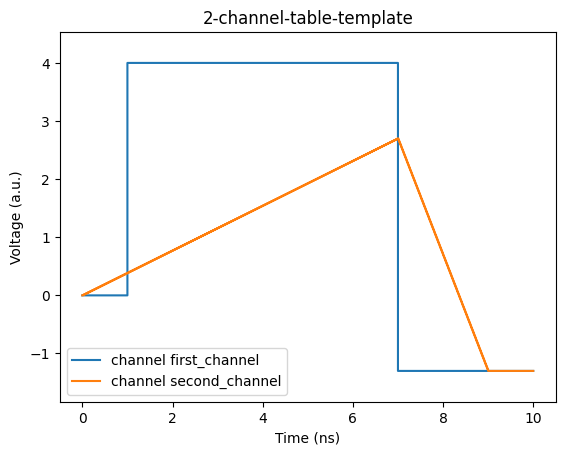

In [1]:
from qupulse.pulses import TablePT
from qupulse.plotting import plot

table_template = TablePT(identifier='2-channel-table-template',
                         entries={'first_channel' : [(0, 0),
                                                     (1, 4),
                                                     ('foo', 'bar'),
                                                     (10, 0)],
                                  'second_channel': [(0, 0),
                                                     ('foo', 2.7, 'linear'),
                                                     (9, 'bar', 'linear')]}
                        )

parameters = dict(
    foo=7,
    bar=-1.3
)
_ = plot(table_template, parameters, sample_rate=100)
print("The number of channels in table_template is {}.".format(table_template.num_channels))

# Combining Templates: `AtomicMultiChannelPulseTemplate`

`AtomicMultiChannelPulseTemplate`(`AtomicMultiChannelPT`) allows to compose a multi-channel template out of atomic (i.e., no control flow) templates of equal duration. It allows to reassign channel indices of the channels of its subtemplates. The constructor is similar to the one of `SequencePulseTemplate` and expects subtemplates (including parameter and channel mappings if required).

The following example will combine the two-channel table pulse template `table_template` from above and a function pulse template `function_template` to a three-channel template `template`. We reassign indices such that channel 'rectangle' of the new `template` is channel 'first_channel' and 'triangle' is channel 'second_channel' of `table_template`. Furthermore the parameters get remapped. `function_template` doesn't get changed at all.

The number of channels in function_template is 1.
The number of channels in template is 3.


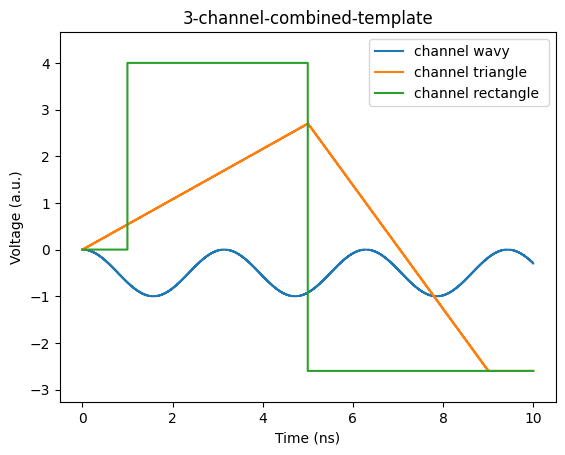

In [2]:
from qupulse.pulses import FunctionPT, AtomicMultiChannelPT

function_template = FunctionPT('-sin(t)**2', '10', identifier='function-template', channel='wavy')

template = AtomicMultiChannelPT(
    function_template,
    (table_template, dict(foo='5', bar='2 * hugo'), {'first_channel': 'rectangle ', 'second_channel': 'triangle'}),
    identifier='3-channel-combined-template'
)

_ = plot(template, dict(hugo=-1.3), sample_rate=100)
print("The number of channels in function_template is {}.".format(function_template.num_channels))
print("The number of channels in template is {}.".format(template.num_channels))

The constructor of `AtomicMultiChannelPulseTemplate` expects its subtemplates as positional arguments. Each of positional arguments is required to be either a `AtomicPulseTemplate`, a `MappingPulseTemplate` that wraps an `AtomicPulseTemplate` or a tuple that can be passed to `MappingPulseTemplate.from_tuple`(more examples in [Mapping with the MappingPulseTemplate](00MappingTemplate.ipynb)). The sets of channels on which the subtemplates are defined has to be distinct.
Note that an exception will be raised during the sampling of the waveforms (i.e., during the sequencing process) if the subtemplates have different length.

## Instantionation duration check
By default the AtomicMultiChannelPulseTemplate checks whether the durations are equal on construction. It is possible to do this check during instantiation (when create_program is called) by providing the `duration` keyword argument. This can either be an expression or `True`. If it is an expression all subwaveforms have to have a duration equal to it. If it is `True` all waveforms have to have an unspecified equal duration.

In [3]:
from qupulse.pulses import FunctionPT, AtomicMultiChannelPT

template_a = FunctionPT('-sin(t)**2', 'duration_a', channel='a')
template_b = FunctionPT('-cos(t)**2', 'duration_b', channel='b')

try:
    # instantiation duration check
    template = AtomicMultiChannelPT(
        template_a,
        template_b,
        identifier='3-channel-combined-template'
    )
except ValueError as err:
    print('Instantiation duration check:')
    print(err)

# instantiation duration check with specified value
template_specified = AtomicMultiChannelPT(
    template_a,
    template_b,
    duration='my_duration'
)
template_specified.create_program(parameters=dict(duration_a=3, duration_b=3, my_duration=3))
try:
    template_specified.create_program(parameters=dict(duration_a=3, duration_b=3, my_duration=4))
except ValueError as err:
    print()
    print('Instantionation duration check with specified value')
    print(err.args[0], err.args[1])



Instantionation duration check with specified value
The duration does not equal the expected duration 4


## Multiple Channels in Non-Atomic Templates

All higher order template, i.e., `SequencePulseTemplate` and `ForLoopPulseTemplate` and `RepetitionPulseTemplate`, also support multiple channels insofar as that they can be composed using multi-channel atomic templates as subtemplates. They require that all these subtemplates define the same channels and raise an exception if that is not the case. The following example constructs a `SequencePulseTempate` `sequence_template` by chaining the above defined two-channel `table_template`. In the second instance of `table_template` in the sequence, we swap the channels by wrapping a `MappingPulseTemplate` around it.

The number of channels in sequence_template is 2.


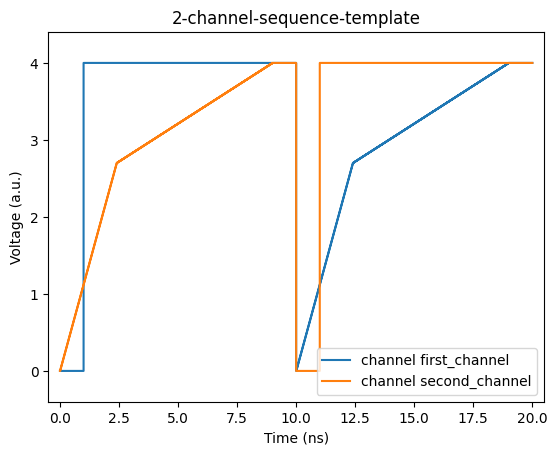

In [4]:
from qupulse.pulses import SequencePT

sequence_template = SequencePT(
    (table_template, dict(foo='1.2 * hugo', bar='hugo ** 2')),
    (table_template, dict(foo='1.2 * hugo', bar='hugo ** 2'), {'first_channel': 'second_channel', 
                                                               'second_channel': 'first_channel'}),
    identifier='2-channel-sequence-template'
)

plot(sequence_template, dict(hugo=2), sample_rate=100)
print("The number of channels in sequence_template is {}.".format(sequence_template.num_channels))